In [146]:
import optuna
from optuna.samplers import TPESampler
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
# from joblib import dump

In [147]:
# CUDA
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE.type

'cuda'

In [148]:
# Fix random seed
seed = 42
torch.manual_seed(seed)
if DEVICE.type == 'cuda':
	torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
sampler = TPESampler(seed=seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [149]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Pre-processing input data

In [150]:
def bits_to_MiB(row):
	# verify if has string ' MiB'
	if 'MiB' in str(row):
		row = row.replace(' MiB', '')
		row = float(row)
	else:
		row = float(row) / np.power(2, 20)
	return row


def MHz_to_GHz(row):
	# verify if has string ' GHz'
	if 'GHz' in str(row):
		row = row.replace(' GHz', '')
		# convert to float
		row = float(row)
	else:
		row = row.replace(' MHz', '')
		row = float(row) / 1000
	return row

In [151]:
results_df = pd.read_csv('../results_new/execution_time.csv')
results_savio_df = pd.read_csv('../results_savio_new/execution_time.csv')
results_df = pd.concat([results_df, results_savio_df], ignore_index=True)
# preprocessing
results_df['total_cpu_usage'] = results_df['total_cpu_usage'].str.replace('%', '').astype(float) / 100
results_df['max_ram_usage'] = results_df['max_ram_usage'] / 1024
results_df['l2_cache_size'] = results_df['l2_cache_size'].apply(bits_to_MiB)
results_df['l3_cache_size'] = results_df['l3_cache_size'].apply(bits_to_MiB)
results_df['ghz_actual_friendly'] = results_df['hz_actual_friendly'].apply(MHz_to_GHz)
results_df['ghz_advertised_friendly'] = results_df['hz_advertised_friendly'].str.replace('GHz', '').astype(float)
results_df = results_df.drop(columns=['hz_actual_friendly', 'hz_advertised_friendly', 'arch', 'vendor_id_raw'])

In [152]:
# Make the target dataset
target_df = results_df[['total_time', 'brand_raw', 'count', 'l2_cache_size', 'l3_cache_size', 'l2_cache_line_size', 'l2_cache_associativity', 'ghz_advertised_friendly', 'benchmark']].copy()
# Rename columns to *_target
target_df = target_df.rename(columns={
    'total_time': 'total_time_target',
    'brand_raw': 'brand_raw_target',
    'count': 'count_target',
    'l2_cache_size': 'l2_cache_size_target',
    'l3_cache_size': 'l3_cache_size_target',
    'l2_cache_line_size': 'l2_cache_line_size_target',
    'l2_cache_associativity': 'l2_cache_associativity_target',
    'ghz_advertised_friendly': 'ghz_advertised_friendly_target',
})

dataset_df = pd.merge(results_df, target_df, how='inner', on='benchmark')
dataset_df = dataset_df[dataset_df['brand_raw'] != dataset_df['brand_raw_target']]
dataset_df.head(2)

,total_time,total_cpu_usage,max_ram_usage,brand_raw,count,l2_cache_size,l3_cache_size,l2_cache_line_size,l2_cache_associativity,benchmark,ghz_actual_friendly,ghz_advertised_friendly,total_time_target,brand_raw_target,count_target,l2_cache_size_target,l3_cache_size_target,l2_cache_line_size_target,l2_cache_associativity_target,ghz_advertised_friendly_target
5,13.47,0.99,1436.714844,Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz,12,1.5,12.0,256,6,KNP,4.1729,2.9,45.91,13th Gen Intel(R) Core(TM) i5-1335U,12,7.5,12.0,1280,7,2.496
6,13.47,0.99,1436.714844,Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz,12,1.5,12.0,256,6,KNP,4.1729,2.9,25.77,13th Gen Intel(R) Core(TM) i5-1335U,12,7.5,12.0,1280,7,2.496


In [153]:
# remove one computer for testing
g_train = dataset_df[(dataset_df['brand_raw'] != '13th Gen Intel(R) Core(TM) i5-1335U') & (dataset_df['brand_raw_target'] != '13th Gen Intel(R) Core(TM) i5-1335U')]
g_test = dataset_df[dataset_df['brand_raw_target'] == '13th Gen Intel(R) Core(TM) i5-1335U']

In [154]:
mm_df = dataset_df[dataset_df['benchmark'].isin(['MATRIX_MULT', 'MATRIX_MULT2', 'MATRIX_MULT3'])]
# remove one computer for testing
mm_train = mm_df[(mm_df['brand_raw'] != '13th Gen Intel(R) Core(TM) i5-1335U') & (mm_df['brand_raw_target'] != '13th Gen Intel(R) Core(TM) i5-1335U')]
mm_test = mm_df[mm_df['brand_raw_target'] == '13th Gen Intel(R) Core(TM) i5-1335U']

In [155]:
st_df = dataset_df[~dataset_df['benchmark'].isin(['MATRIX_MULT', 'MATRIX_MULT2', 'MATRIX_MULT3'])]
# remove one computer for testing
st_train = st_df[(st_df['brand_raw'] != '13th Gen Intel(R) Core(TM) i5-1335U') & (st_df['brand_raw_target'] != '13th Gen Intel(R) Core(TM) i5-1335U')]
st_test = st_df[st_df['brand_raw_target'] == '13th Gen Intel(R) Core(TM) i5-1335U']

In [156]:
# load test dataset
# g_test = pd.read_csv('csv/g_test.csv')
# st_test = pd.read_csv('csv/st_test.csv')
# mm_test = pd.read_csv('csv/mm_test.csv')

In [157]:
target = 'total_time_target'
features = mm_test.columns.copy().drop(target).drop(['benchmark','brand_raw', 'brand_raw_target'])
features_st = features.copy().drop(['count', 'count_target'])

In [158]:
# general data
## split data
X_g_train = g_train[features]
y_g_train = g_train[target]

X_g_test = g_test[features]
y_g_test = g_test[target]

## normalize data
x_g_scaler = MinMaxScaler(feature_range=(0, 1))
X_g_train = x_g_scaler.fit_transform(X_g_train)
X_g_test = x_g_scaler.transform(X_g_test)
y_g_scaler = MinMaxScaler(feature_range=(0, 1))
y_g_train = y_g_scaler.fit_transform(y_g_train.values.reshape(-1, 1))
y_g_test = y_g_scaler.transform(y_g_test.values.reshape(-1, 1))

## convert to tensor
X_g_train = torch.tensor(X_g_train, dtype=torch.float32)
X_g_test = torch.tensor(X_g_test, dtype=torch.float32)
y_g_train = torch.tensor(y_g_train, dtype=torch.float32)
y_g_test = torch.tensor(y_g_test, dtype=torch.float32)

In [159]:
# single thread data
## split data
X_st_train = st_train[features_st]
y_st_train = st_train[target]

X_st_test = st_test[features_st]
y_st_test = st_test[target]

## normalize data
x_st_scaler = MinMaxScaler(feature_range=(0, 1))
X_st_train = x_st_scaler.fit_transform(X_st_train)
X_st_test = x_st_scaler.transform(X_st_test)
y_st_scaler = MinMaxScaler(feature_range=(0, 1))
y_st_train = y_st_scaler.fit_transform(y_st_train.values.reshape(-1, 1))
y_st_test = y_st_scaler.transform(y_st_test.values.reshape(-1, 1))

## convert to tensor
X_st_train = torch.tensor(X_st_train, dtype=torch.float32)
X_st_test = torch.tensor(X_st_test, dtype=torch.float32)
y_st_train = torch.tensor(y_st_train, dtype=torch.float32)
y_st_test = torch.tensor(y_st_test, dtype=torch.float32)

In [160]:
# multi thread data
## split data
X_mm_train = mm_train[features]
y_mm_train = mm_train[target]

X_mm_test = mm_test[features]
y_mm_test = mm_test[target]

## normalize data
x_mm_scaler = MinMaxScaler(feature_range=(0, 1))
X_mm_train = x_mm_scaler.fit_transform(X_mm_train)
X_mm_test = x_mm_scaler.transform(X_mm_test)
y_mm_scaler = MinMaxScaler(feature_range=(0, 1))
y_mm_train = y_mm_scaler.fit_transform(y_mm_train.values.reshape(-1, 1))
y_mm_test = y_mm_scaler.transform(y_mm_test.values.reshape(-1, 1))

## convert to tensor
X_mm_train = torch.tensor(X_mm_train, dtype=torch.float32)
X_mm_test = torch.tensor(X_mm_test, dtype=torch.float32)
y_mm_train = torch.tensor(y_mm_train, dtype=torch.float32)
y_mm_test = torch.tensor(y_mm_test, dtype=torch.float32)

In [161]:
if DEVICE.type == 'cuda':
	# move to DEVICE
	X_g_train = X_g_train.to(DEVICE)
	y_g_train = y_g_train.to(DEVICE)
	X_g_test = X_g_test.to(DEVICE)
	y_g_test = y_g_test.to(DEVICE)

	X_st_train = X_st_train.to(DEVICE)
	y_st_train = y_st_train.to(DEVICE)
	X_st_test = X_st_test.to(DEVICE)
	y_st_test = y_st_test.to(DEVICE)

	X_mm_train = X_mm_train.to(DEVICE)
	y_mm_train = y_mm_train.to(DEVICE)
	X_mm_test = X_mm_test.to(DEVICE)
	y_mm_test = y_mm_test.to(DEVICE)

# Model

In [109]:
def inv_scaling(y, y_scaler, d=False):
    if d:
        return y_scaler.inverse_transform(y.detach().cpu().numpy().reshape(-1, 1))
    return y_scaler.inverse_transform(y.cpu().numpy().reshape(-1, 1))

In [110]:
class FeedforwardModel(nn.Module):
	def __init__(self, input_dim, output_dim, dropout=0.1):
		super(FeedforwardModel, self).__init__()
		# layers
		self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(32, output_dim),
			nn.ReLU()
        )
	
	def forward(self, x):
		return self.model(x)

In [111]:
def objective(trial: optuna.Trial, X_train, y_train, X_test, y_test, y_scaler, input_dim, output_dim):
	# Definimos los hiperparámetros a buscar
	dropout = trial.suggest_float('dropout', 0.1, 0.5)
	learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
	weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
	num_epochs = trial.suggest_int('num_epochs', 10, 100)

	# model initialization 
	model = FeedforwardModel(input_dim, output_dim, dropout)
	if DEVICE.type == 'cuda':
		model = model.to(DEVICE)
	criterion = nn.MSELoss()
	optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
	# training
	y_train_inv_scaled = inv_scaling(y_train, y_scaler)
	y_test_inv_scaled = inv_scaling(y_test, y_scaler)
	model.train()
	for epoch in range(num_epochs):
		optimizer.zero_grad()
		output = model(X_train)
		loss = criterion(output, y_train)
		loss.backward()
		optimizer.step()
		
	# evaluation
	model.eval()
	output_inv_scaled = inv_scaling(output, y_scaler, True)
	loss_inv_scaled = mean_squared_error(y_train_inv_scaled, output_inv_scaled)
	with torch.no_grad():
		predictions = model(X_test)
		val_loss = criterion(predictions, y_test)
		
		predictions_inv_scaled = inv_scaling(predictions, y_scaler)
		val_loss_inv_scaled = mean_squared_error(y_test_inv_scaled, predictions_inv_scaled)
		# trial.report(val_loss.item(), epoch+1)
		# if trial.should_prune():
		# 	raise optuna.TrialPruned()

	print(f"Trial: {trial.number} - Loss: {loss_inv_scaled.item()} - Val Loss: {val_loss_inv_scaled.item()}")
	return val_loss.item()

# Hyperparameters Optimization

In [112]:
n_trials = 250
study_g = None
study_st = None
study_mm = None

## General

In [113]:
# configuration optuna
study_g = optuna.create_study(direction='minimize', sampler=sampler)
study_g.optimize(lambda trial: objective(trial, X_g_train, y_g_train, X_g_test, y_g_test, y_g_scaler, len(features), 1), n_trials=n_trials)

Trial: 0 - Loss: 43.98611068725586 - Val Loss: 364.3743591308594
Trial: 1 - Loss: 607.3947143554688 - Val Loss: 1828.3349609375
Trial: 2 - Loss: 610.1693115234375 - Val Loss: 1828.3349609375
Trial: 3 - Loss: 370.1713562011719 - Val Loss: 1410.17724609375
Trial: 4 - Loss: 278.612060546875 - Val Loss: 992.5170288085938
Trial: 5 - Loss: 592.0574340820312 - Val Loss: 1828.3349609375
Trial: 6 - Loss: 92.34789276123047 - Val Loss: 401.1322937011719
Trial: 7 - Loss: 334.6427001953125 - Val Loss: 936.6837158203125
Trial: 8 - Loss: 28.247753143310547 - Val Loss: 358.1264953613281
Trial: 9 - Loss: 346.5751037597656 - Val Loss: 824.8523559570312
Trial: 10 - Loss: 267.4100646972656 - Val Loss: 884.3612670898438
Trial: 11 - Loss: 38.40919494628906 - Val Loss: 368.49053955078125
Trial: 12 - Loss: 44.13488006591797 - Val Loss: 371.20330810546875
Trial: 13 - Loss: 75.58802795410156 - Val Loss: 416.461669921875
Trial: 14 - Loss: 36.61722946166992 - Val Loss: 328.569091796875
Trial: 15 - Loss: 610.16931

In [114]:
# Results
print(f'Número de pruebas: {len(study_g.trials)}')
trial = study_g.best_trial
print(f'Mejor prueba: {trial.number}')
print(f'Mejores parametros: {trial.params}')
print(f'Mejor valor de pérdida en validación: {y_g_scaler.inverse_transform(np.reshape(trial.value, (-1,1))).item()}')

Número de pruebas: 250
Mejor prueba: 36
Mejores parametros: {'dropout': 0.18767201455822136, 'learning_rate': 0.0034627375867397102, 'weight_decay': 0.00533177762515262, 'num_epochs': 61}
Mejor valor de pérdida en validación: 5.8314826213568445


## Single Thread

In [115]:
# configuration optuna
study_st = optuna.create_study(direction='minimize', sampler=sampler)
study_st.optimize(lambda trial: objective(trial, X_st_train, y_st_train, X_st_test, y_st_test, y_st_scaler, len(features_st), 1), n_trials=n_trials)

Trial: 0 - Loss: 248.1211395263672 - Val Loss: 834.6378173828125
Trial: 1 - Loss: 272.6722717285156 - Val Loss: 973.3232421875
Trial: 2 - Loss: 341.87396240234375 - Val Loss: 1116.2615966796875
Trial: 3 - Loss: 45.30317306518555 - Val Loss: 318.8092041015625
Trial: 4 - Loss: 637.1146240234375 - Val Loss: 1867.0008544921875
Trial: 5 - Loss: 355.838134765625 - Val Loss: 1351.2501220703125
Trial: 6 - Loss: 219.05467224121094 - Val Loss: 812.1194458007812
Trial: 7 - Loss: 68.21792602539062 - Val Loss: 343.7408752441406
Trial: 8 - Loss: 39.2988395690918 - Val Loss: 295.9520568847656
Trial: 9 - Loss: 585.2438354492188 - Val Loss: 1853.75634765625
Trial: 10 - Loss: 124.35733795166016 - Val Loss: 449.6277160644531
Trial: 11 - Loss: 54.588497161865234 - Val Loss: 309.0706481933594
Trial: 12 - Loss: 70.04273986816406 - Val Loss: 313.05255126953125
Trial: 13 - Loss: 40.5504035949707 - Val Loss: 319.8132629394531
Trial: 14 - Loss: 158.82937622070312 - Val Loss: 612.092529296875
Trial: 15 - Loss: 2

In [116]:
# Results
print(f'Número de pruebas: {len(study_st.trials)}')
trial = study_st.best_trial
print(f'Mejor prueba: {trial.number}')
print(f'Mejores parametros: {trial.params}')
print(f'Mejor valor de pérdida en validación: {y_st_scaler.inverse_transform(np.reshape(trial.value, (-1,1))).item()}')

Número de pruebas: 250
Mejor prueba: 233
Mejores parametros: {'dropout': 0.1339347969753616, 'learning_rate': 0.008914667480590114, 'weight_decay': 1.697630926432998e-05, 'num_epochs': 39}
Mejor valor de pérdida en validación: 6.934620843166485


## Multi Thread

In [139]:
# configuration optuna
study_mm = optuna.create_study(direction='minimize', sampler=sampler)
study_mm.optimize(lambda trial: objective(trial, X_mm_train, y_mm_train, X_mm_test, y_mm_test, y_mm_scaler, len(features), 1), n_trials=n_trials)

Trial: 0 - Loss: 44.394569396972656 - Val Loss: 846.0711669921875
Trial: 1 - Loss: 54.63078308105469 - Val Loss: 449.5064697265625
Trial: 2 - Loss: 74.39256286621094 - Val Loss: 574.72314453125
Trial: 3 - Loss: 95.76054382324219 - Val Loss: 695.6268920898438
Trial: 4 - Loss: 23.411027908325195 - Val Loss: 796.185546875
Trial: 5 - Loss: 130.1413116455078 - Val Loss: 538.4951171875
Trial: 6 - Loss: 199.01055908203125 - Val Loss: 1093.9622802734375
Trial: 7 - Loss: 199.01055908203125 - Val Loss: 1093.9622802734375
Trial: 8 - Loss: 199.01055908203125 - Val Loss: 1093.9622802734375
Trial: 9 - Loss: 19.407196044921875 - Val Loss: 774.39990234375
Trial: 10 - Loss: 121.43113708496094 - Val Loss: 650.5045776367188
Trial: 11 - Loss: 186.98838806152344 - Val Loss: 1084.19189453125
Trial: 12 - Loss: 198.37374877929688 - Val Loss: 1093.9622802734375
Trial: 13 - Loss: 100.35196685791016 - Val Loss: 587.0381469726562
Trial: 14 - Loss: 104.0997543334961 - Val Loss: 428.5005798339844
Trial: 15 - Loss: 

In [140]:
# Results
print(f'Trials quantity: {len(study_mm.trials)}')
trial = study_mm.best_trial
print(f'Mejor prueba: {trial.number}')
print(f'Mejores parametros: {trial.params}')
print(f'Mejor valor de pérdida en validación: {y_mm_scaler.inverse_transform(np.reshape(trial.value, (-1,1))).item()}')

Trials quantity: 250
Mejor prueba: 89
Mejores parametros: {'dropout': 0.26945275246930317, 'learning_rate': 0.000257908225503795, 'weight_decay': 0.00362739378434928, 'num_epochs': 71}
Mejor valor de pérdida en validación: 9.73840263232589


# Training

In [119]:
models_folder = '../models/feedforward'
output_dim = 1

In [120]:
def plot_loss(history):
	epochs = np.arange(1, len(history["loss"])+1)
	plt.figure(figsize=(10, 5))
	plt.plot(epochs, history["val_loss"], 'r', label='Validation loss')
	plt.plot(epochs, history["loss"], 'b', label='Training loss')
	plt.title('Training and Validation loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.legend()
	plt.show()

def evaluate_model(model, X_test, y_test, y_scaler):
	model.eval()
	with torch.no_grad():
		preds = model(X_test)
		mse = mean_squared_error(inv_scaling(y_test, y_scaler), inv_scaling(preds, y_scaler))
		mae = mean_absolute_error(inv_scaling(y_test, y_scaler), inv_scaling(preds, y_scaler))
	print(f"MSE: {mse} - RMSE: {np.sqrt(mse)} - MAE: {mae}")

In [162]:
# dump(x_g_scaler, f'{models_folder}/x_g_scaler.joblib')
# dump(x_st_scaler, f'{models_folder}/x_st_scaler.joblib')
# dump(x_mm_scaler, f'{models_folder}/x_mm_scaler.joblib')
# dump(y_g_scaler, f'{models_folder}/y_g_scaler.joblib')
# dump(y_st_scaler, f'{models_folder}/y_st_scaler.joblib')
# dump(y_mm_scaler, f'{models_folder}/y_mm_scaler.joblib')

['../models/feedforward/y_mm_scaler.joblib']

## General

In [122]:
input_dim = len(features)
# hyperparameters
if study_g is not None:
	dropout = study_g.best_trial.params['dropout']
	lr = study_g.best_trial.params['learning_rate']
	wd = study_g.best_trial.params['weight_decay']
	num_epochs = study_g.best_trial.params['num_epochs']
else:
	dropout = 0.34320154768810407
	lr = 1.2004574722381897e-05
	wd = 0.0010581386258568981
	num_epochs = 19

In [123]:
# general model initialization
model_g = FeedforwardModel(input_dim, output_dim)
if DEVICE.type == 'cuda':
	model_g = model_g.to(DEVICE)
criterion_g = nn.MSELoss()
optimizer_g = optim.AdamW(model_g.parameters(), lr=lr, weight_decay=wd)

history = {
	'loss': [],
	'val_loss': []
}

y_train_inv_scaled = inv_scaling(y_g_train, y_g_scaler)
y_test_inv_scaled = inv_scaling(y_g_test, y_g_scaler)
model_g.train()
for epoch in range(num_epochs):
	optimizer_g.zero_grad()
	output = model_g(X_g_train)
	loss = criterion_g(output, y_g_train)
	loss.backward()
	optimizer_g.step()
	# validation
	#if (epoch+1) % 10 == 0 or epoch == num_epochs-1:
	model_g.eval()
	output_inv_scaled = inv_scaling(output, y_g_scaler, True)
	loss_inv_scaled = mean_squared_error(y_train_inv_scaled, output_inv_scaled)
	with torch.no_grad():
		predictions = model_g(X_g_test)
		val_loss = criterion_g(predictions, y_g_test)

		predictions_inv_scaled = inv_scaling(predictions, y_g_scaler)
		val_loss_inv_scaled = mean_squared_error(y_test_inv_scaled, predictions_inv_scaled)
		history['loss'].append(loss_inv_scaled.item())
		history['val_loss'].append(val_loss_inv_scaled.item())
	print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss_inv_scaled.item()}, Val Loss: {val_loss_inv_scaled.item()}')
	model_g.train()

Epoch 1/61, Loss: 484.9385986328125, Val Loss: 1324.670654296875
Epoch 2/61, Loss: 329.7924499511719, Val Loss: 958.036865234375
Epoch 3/61, Loss: 280.1064453125, Val Loss: 816.0113525390625
Epoch 4/61, Loss: 315.2976989746094, Val Loss: 800.1168212890625
Epoch 5/61, Loss: 316.73370361328125, Val Loss: 824.6640625
Epoch 6/61, Loss: 287.4706726074219, Val Loss: 878.3641967773438
Epoch 7/61, Loss: 265.553466796875, Val Loss: 947.4678344726562
Epoch 8/61, Loss: 251.4740753173828, Val Loss: 1008.2410888671875
Epoch 9/61, Loss: 252.61309814453125, Val Loss: 1046.422119140625
Epoch 10/61, Loss: 257.1177062988281, Val Loss: 1058.0242919921875
Epoch 11/61, Loss: 253.98118591308594, Val Loss: 1041.0
Epoch 12/61, Loss: 248.18479919433594, Val Loss: 998.6490478515625
Epoch 13/61, Loss: 238.67918395996094, Val Loss: 937.2300415039062
Epoch 14/61, Loss: 227.4055938720703, Val Loss: 865.943115234375
Epoch 15/61, Loss: 215.48956298828125, Val Loss: 793.1516723632812
Epoch 16/61, Loss: 208.70956420898

Epoch 37/61, Loss: 76.07137298583984, Val Loss: 435.81072998046875
Epoch 38/61, Loss: 72.8112564086914, Val Loss: 433.60595703125
Epoch 39/61, Loss: 69.02210998535156, Val Loss: 402.81103515625
Epoch 40/61, Loss: 65.80315399169922, Val Loss: 361.6828308105469
Epoch 41/61, Loss: 62.1092643737793, Val Loss: 331.6585693359375
Epoch 42/61, Loss: 61.6218147277832, Val Loss: 329.0335693359375
Epoch 43/61, Loss: 58.614234924316406, Val Loss: 346.813720703125
Epoch 44/61, Loss: 55.963626861572266, Val Loss: 367.4379577636719
Epoch 45/61, Loss: 54.13032150268555, Val Loss: 373.83013916015625
Epoch 46/61, Loss: 53.53120040893555, Val Loss: 357.8006286621094
Epoch 47/61, Loss: 52.5912971496582, Val Loss: 331.2362060546875
Epoch 48/61, Loss: 52.230587005615234, Val Loss: 314.2691345214844
Epoch 49/61, Loss: 52.954429626464844, Val Loss: 315.970458984375
Epoch 50/61, Loss: 52.2952880859375, Val Loss: 330.17742919921875
Epoch 51/61, Loss: 50.989166259765625, Val Loss: 346.39593505859375
Epoch 52/61,

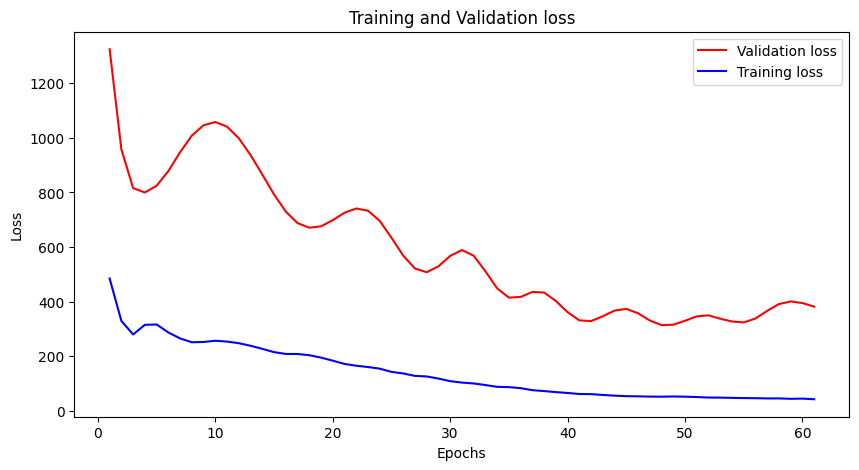

MSE: 381.93585205078125 - RMSE: 19.54317855834961 - MAE: 16.53575325012207


In [124]:
plot_loss(history)
evaluate_model(model_g, X_g_test, y_g_test, y_g_scaler)

In [125]:
# save model
torch.save(model_g, f'{models_folder}/general.pt')

## Single Thread

In [126]:
input_dim = len(features_st)
# hyperparameters
if study_st is not None:
	dropout = study_st.best_trial.params['dropout']
	lr = study_st.best_trial.params['learning_rate']
	wd = study_st.best_trial.params['weight_decay']
	num_epochs = study_st.best_trial.params['num_epochs']
else:
	dropout = 0.22873536986042736
	lr = 3.06810748457367e-05
	wd = 0.002521323748549924
	num_epochs = 47

In [127]:
# single thread model initialization
model_st = FeedforwardModel(input_dim, output_dim)
if DEVICE.type == 'cuda':
	model_st = model_st.to(DEVICE)
criterion_st = nn.MSELoss()
optimizer_st = optim.AdamW(model_st.parameters(), lr=lr, weight_decay=wd)

history = {
	'loss': [],
	'val_loss': []
}

y_train_inv_scaled = inv_scaling(y_st_train, y_st_scaler)
y_test_inv_scaled = inv_scaling(y_st_test, y_st_scaler)
model_st.train()
for epoch in range(num_epochs):
	optimizer_st.zero_grad()
	output = model_st(X_st_train)
	loss = criterion_st(output, y_st_train)
	loss.backward()
	optimizer_st.step()
	# validation
	#if (epoch+1) % 10 == 0 or epoch == num_epochs-1:
	model_st.eval()
	output_inv_scaled = inv_scaling(output, y_st_scaler, True)
	loss_inv_scaled = mean_squared_error(y_train_inv_scaled, output_inv_scaled)
	with torch.no_grad():
		predictions = model_st(X_st_test)
		val_loss = criterion_st(predictions, y_st_test)

		predictions_inv_scaled = inv_scaling(predictions, y_st_scaler)
		val_loss_inv_scaled = mean_squared_error(y_test_inv_scaled, predictions_inv_scaled)
		history['loss'].append(loss_inv_scaled.item())
		history['val_loss'].append(val_loss_inv_scaled.item())
	print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss_inv_scaled.item()}, Val Loss: {val_loss_inv_scaled.item()}')
	model_st.train()

Epoch 1/39, Loss: 387.32525634765625, Val Loss: 1607.4932861328125
Epoch 2/39, Loss: 453.3335876464844, Val Loss: 1289.7396240234375
Epoch 3/39, Loss: 335.4543762207031, Val Loss: 1072.69775390625
Epoch 4/39, Loss: 275.6527404785156, Val Loss: 999.9205932617188
Epoch 5/39, Loss: 275.767333984375, Val Loss: 975.7141723632812
Epoch 6/39, Loss: 283.2395935058594, Val Loss: 968.8892211914062
Epoch 7/39, Loss: 279.755859375, Val Loss: 971.3721923828125
Epoch 8/39, Loss: 269.3940734863281, Val Loss: 981.7075805664062
Epoch 9/39, Loss: 257.1795349121094, Val Loss: 997.5674438476562
Epoch 10/39, Loss: 248.389892578125, Val Loss: 1014.4178466796875
Epoch 11/39, Loss: 243.2210235595703, Val Loss: 1025.2681884765625
Epoch 12/39, Loss: 238.7543182373047, Val Loss: 1022.677734375
Epoch 13/39, Loss: 232.6878662109375, Val Loss: 998.3753051757812
Epoch 14/39, Loss: 225.2058563232422, Val Loss: 947.7007446289062
Epoch 15/39, Loss: 214.71182250976562, Val Loss: 880.6483764648438
Epoch 16/39, Loss: 204.

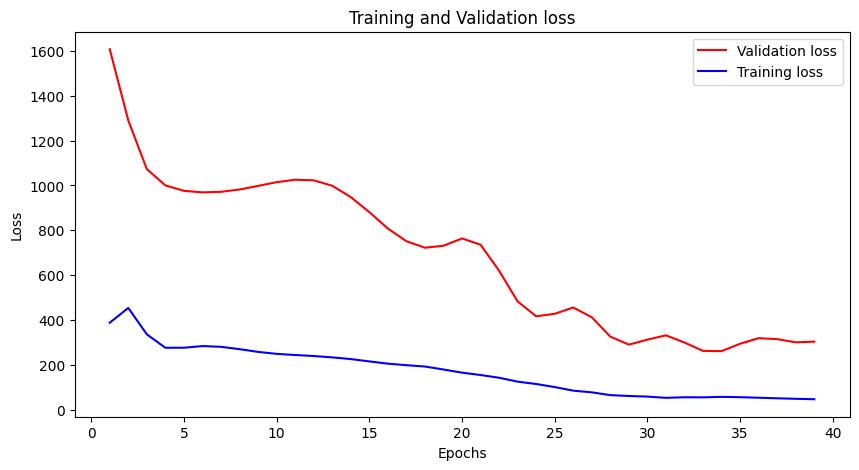

MSE: 302.9412841796875 - RMSE: 17.405208587646484 - MAE: 13.244939804077148


In [128]:
plot_loss(history)
evaluate_model(model_st, X_st_test, y_st_test, y_st_scaler)

In [129]:
# save model
torch.save(model_st, f'{models_folder}/single_thread.pt')

## Multi Thread

In [141]:
input_dim = len(features)
# hyperparameters
if study_st is not None:
	dropout = study_mm.best_trial.params['dropout']
	lr = study_mm.best_trial.params['learning_rate']
	wd = study_mm.best_trial.params['weight_decay']
	num_epochs = study_mm.best_trial.params['num_epochs']
else:
	dropout = 0.40622481909537167
	lr = 1.5169529573314291e-05
	wd = 1.2379849225037556e-05
	num_epochs = 74

In [142]:
# multi thread model initialization
model_mm = FeedforwardModel(input_dim, output_dim)
if DEVICE.type == 'cuda':
	model_mm = model_mm.to(DEVICE)
criterion_mm = nn.MSELoss()
optimizer_mm = optim.AdamW(model_mm.parameters(), lr=lr, weight_decay=wd)

history = {
	'loss': [],
	'val_loss': []
}

y_train_inv_scaled = inv_scaling(y_mm_train, y_mm_scaler)
y_test_inv_scaled = inv_scaling(y_mm_test, y_mm_scaler)
model_mm.train()
for epoch in range(num_epochs):
	optimizer_mm.zero_grad()
	output = model_mm(X_mm_train)
	loss = criterion_mm(output, y_mm_train)
	loss.backward()
	optimizer_mm.step()
	# validation
	#if (epoch+1) % 10 == 0 or epoch == num_epochs-1:
	model_mm.eval()
	output_inv_scaled = inv_scaling(output, y_mm_scaler, True)
	loss_inv_scaled = mean_squared_error(y_train_inv_scaled, output_inv_scaled)
	with torch.no_grad():
		predictions = model_mm(X_mm_test)
		val_loss = criterion_mm(predictions, y_mm_test)

		predictions_inv_scaled = inv_scaling(predictions, y_mm_scaler)
		val_loss_inv_scaled = mean_squared_error(y_test_inv_scaled, predictions_inv_scaled)
		history['loss'].append(loss_inv_scaled.item())
		history['val_loss'].append(val_loss_inv_scaled.item())
	print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss_inv_scaled.item()}, Val Loss: {val_loss_inv_scaled.item()}')
	model_mm.train()

Epoch 1/71, Loss: 137.11082458496094, Val Loss: 752.658203125
Epoch 2/71, Loss: 134.94622802734375, Val Loss: 733.5990600585938
Epoch 3/71, Loss: 132.6553192138672, Val Loss: 714.98046875
Epoch 4/71, Loss: 128.89373779296875, Val Loss: 696.9408569335938
Epoch 5/71, Loss: 126.89083099365234, Val Loss: 679.43603515625
Epoch 6/71, Loss: 125.7572250366211, Val Loss: 662.6576538085938
Epoch 7/71, Loss: 122.65625, Val Loss: 646.5642700195312
Epoch 8/71, Loss: 120.6159896850586, Val Loss: 631.0658569335938
Epoch 9/71, Loss: 118.76283264160156, Val Loss: 616.0967407226562
Epoch 10/71, Loss: 116.20490264892578, Val Loss: 601.7020874023438
Epoch 11/71, Loss: 114.13455963134766, Val Loss: 587.7974853515625
Epoch 12/71, Loss: 112.64869689941406, Val Loss: 574.5420532226562
Epoch 13/71, Loss: 110.51449584960938, Val Loss: 561.9209594726562
Epoch 14/71, Loss: 108.33875274658203, Val Loss: 549.88916015625
Epoch 15/71, Loss: 107.07239532470703, Val Loss: 538.4760131835938
Epoch 16/71, Loss: 106.519828

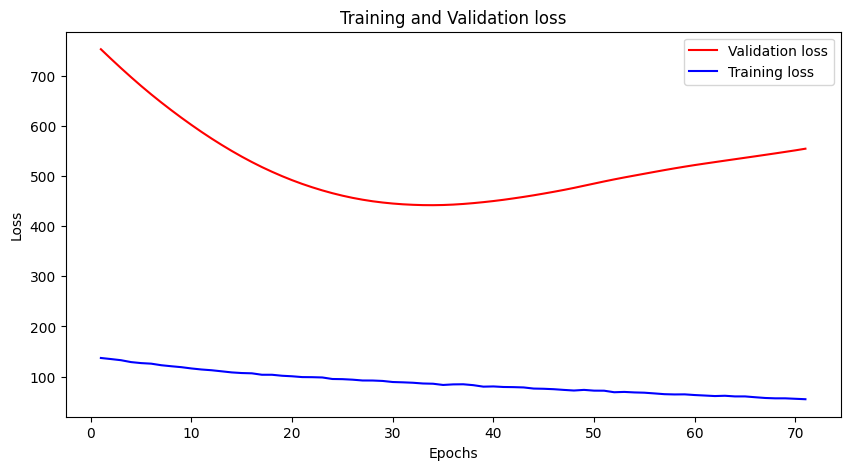

MSE: 554.342529296875 - RMSE: 23.544479370117188 - MAE: 23.4549560546875


In [143]:
plot_loss(history)
evaluate_model(model_mm, X_mm_test, y_mm_test, y_mm_scaler)

In [144]:
# save model
torch.save(model_mm, f'{models_folder}/multi_thread.pt')

# Load models

In [134]:
model_g = torch.load(f'{models_folder}/general.pt').to(DEVICE)
model_st = torch.load(f'{models_folder}/single_thread.pt').to(DEVICE)
model_mm = torch.load(f'{models_folder}/multi_thread.pt').to(DEVICE)

In [135]:
def predict(model, X):
	model.eval()
	with torch.no_grad():
		prediction = model(X)
	return prediction

def describe_val(model, X, y, y_scaler):
	min_instance = {"prediction": float('inf'), "actual": 0, "index": 0}
	max_instance = {"prediction": 0, "actual": 0, "index": 0}
	predictions = predict(model, X)
	predictions = inv_scaling(predictions, y_scaler)
	y_scaled = inv_scaling(y, y_scaler)
	index_min = np.argmin(np.abs(predictions - y_scaled))
	min_instance["prediction"] = predictions[index_min].item()
	min_instance["actual"] = y_scaled[index_min].item()
	min_instance["index"] = index_min
	index_max = np.argmax(np.abs(predictions - y_scaled))
	max_instance["prediction"] = predictions[index_max].item()
	max_instance["actual"] = y_scaled[index_max].item()
	max_instance["index"] = index_max

	return min_instance, max_instance, predictions

In [136]:
# general model
print("Validation set general model")
min_instance, max_instance, predictions = describe_val(model_g, X_g_test, y_g_test, y_g_scaler)
y_scaled = inv_scaling(y_g_test, y_g_scaler)
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("---")
print("Min instance")
print(g_test.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(g_test.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set general model
Mean prediction: 19.01434898376465 | Std actual: 20.891401290893555
Mean actual: 35.04148483276367 | Std actual: 28.83706283569336
Mean Error: 16.53575325012207 | Std Error: 10.416559219360352
---
Min instance
total_time                                                             7.23
total_cpu_usage                                                        0.99
max_ram_usage                                                     31.957031
brand_raw                         Intel(R) Xeon(R) CPU E5-2623 v3 @ 3.00GHz
count                                                                     8
l2_cache_size                                                           2.0
l3_cache_size                                                          10.0
l2_cache_line_size                                                      256
l2_cache_associativity                                                    6
benchmark                                                              TSP2
g

In [137]:
# single thread model
print("Validation set single thread model")
min_instance, max_instance, predictions = describe_val(model_st, X_st_test, y_st_test, y_st_scaler)
y_scaled = inv_scaling(y_st_test, y_st_scaler)
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(st_test.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(st_test.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model
Mean prediction: 22.979158401489258 | Std actual: 20.908021926879883
Mean actual: 34.75261306762695 | Std actual: 31.49396324157715
Mean Error: 13.244939804077148 | Std Error: 11.292160987854004
Min instance
total_time                                                           33.51
total_cpu_usage                                                       0.99
max_ram_usage                                                  1435.382812
brand_raw                         Intel(R) Core(TM) i5-8300H CPU @ 2.30GHz
count                                                                    8
l2_cache_size                                                          1.0
l3_cache_size                                                          8.0
l2_cache_line_size                                                     256
l2_cache_associativity                                                   6
benchmark                                                              KNP
ghz_act

In [145]:
# multi thread model
print("Validation set multi thread model")
min_instance, max_instance, predictions = describe_val(model_mm, X_mm_test, y_mm_test, y_mm_scaler)
y_scaled = inv_scaling(y_mm_test, y_mm_scaler)
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(mm_test.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(mm_test.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set multi thread model
Mean prediction: 13.079045295715332 | Std actual: 1.863642692565918
Mean actual: 36.53400421142578 | Std actual: 0.8569860458374023
Mean Error: 23.4549560546875 | Std Error: 2.051240921020508
Min instance
total_time                                                            3.64
total_cpu_usage                                                      24.31
max_ram_usage                                                  2380.371094
brand_raw                         Intel(R) Xeon(R) Gold 6230 CPU @ 2.10GHz
count                                                                   40
l2_cache_size                                                         40.0
l3_cache_size                                                         27.5
l2_cache_line_size                                                     256
l2_cache_associativity                                                   6
benchmark                                                      MATRIX_MULT
ghz_actual_